# "ArviZ in depth: <code>plot_trace</code>"
> Who said looking at traces wasn't fun?

- toc: true 
- author: Oriol Abril Pla
- badges: true
- categories: [arviz, visualization, plotting]

## Introduction
`plot_trace` is one of the most common plots to assess the convergence of MCMC runs, therefore, it is also one of the most used functions from ArviZ. `plot_trace` has a lot of parameters that allow creating highly customizable plots, but they may not be straightforward to use. There are many reasons that can explain this convolutedness of the arguments and their format, there is no clear culprit: ArviZ has to integrate with several libraries such as xarray and matplotlib which provide amazing features and customizable power, and we'd like to keep when using ArviZ. However, we also aim to keep ArviZ usage simple and with sensible defaults; `plot_xyz(idata)` should generate acceptable results in most situations.

This post aims to be an extension to the API section on [`plot_trace`](https://arviz-devs.github.io/arviz/generated/arviz.plot_trace.html#arviz.plot_trace), focusing mostly on arguments where examples may be lacking and arguments that appear often in questions posted to ArviZ issues.

In [1]:
import arviz as az
import numpy as np
import xarray as xr

rng = np.random.default_rng()

In [2]:
idata = az.load_arviz_data("rugby")

## The `lines` argument
The description about lines in `plot_trace`'s docstring is the following: 

> lines : _list of tuple of (str, dict, array_like), optional_
>
> List of `(var_name, {‘coord’: selection}, [line, positions])` to be overplotted as vertical lines on the density and horizontal lines on the trace.

It is possible that the first thought after reading this line is similar to _"What is with this weird format?"_ Well, this format is actually the stardard way ArviZ uses to iterate over `xarray.Dataset` objects because it contains all the info about the variable and the selected coordinates as well as the values themselves. The main helper function that handles this is `arviz.plots.plot_utils.xarray_var_iter`. 

This section will be a little different from the other ones, and will focus on boosting `plot_trace` capabilities with internal ArviZ functions. You may want to skip to the section altogether of go straigh to the end.

Let's see what `xarray_var_iter` does with a simple dataset. We will create a dataset with two variables: `a` will be a 2x3 matrix and `b` will be a scalar. In addition, the dimensions of `a` will be labeled.

In [3]:
ds = xr.Dataset({
    "a": (("pos", "direction"), rng.normal(size=(2,3))),
    "b": 12, 
    "pos": ["top", "bottom"],
    "direction": ["x", "y", "z"]
})
ds

<xarray.Dataset>
Dimensions:    (direction: 3, pos: 2)
Coordinates:
  * pos        (pos) <U6 'top' 'bottom'
  * direction  (direction) <U1 'x' 'y' 'z'
Data variables:
    a          (pos, direction) float64 -0.5907 0.2168 1.083 ... -1.204 0.5953
    b          int64 12

In [4]:
from arviz.plots.plot_utils import xarray_var_iter
for var_name, sel, values in xarray_var_iter(ds):
    print(var_name, sel, values)

a {'pos': 'top', 'direction': 'x'} -0.5907012346747548
a {'pos': 'top', 'direction': 'y'} 0.2168026938959405
a {'pos': 'top', 'direction': 'z'} 1.0833758233056274
a {'pos': 'bottom', 'direction': 'x'} -1.0639283235388908
a {'pos': 'bottom', 'direction': 'y'} -1.203687757297412
a {'pos': 'bottom', 'direction': 'z'} 0.5953087203610695
b {} 12


`xarray_var_iter` has iterated over every single scalar value without loosing track of where did every value come from. We can also modify the behaviour to skip some dimensions (i.e. in ArviZ we generally iterate over data dimensions and skip `chain` and `draw` dims). 

In [5]:
for var_name, sel, values in xarray_var_iter(ds, skip_dims={"direction"}):
    print(var_name, sel, values)

a {'pos': 'top'} [-0.59070123  0.21680269  1.08337582]
a {'pos': 'bottom'} [-1.06392832 -1.20368776  0.59530872]
b {} 12


Now that we know about `xarray_var_iter` and what it does, we can use it to generate a list in the required format directly from xarray objects. Let's say for example we were interested in plotting the mean as a line in the trace plot:

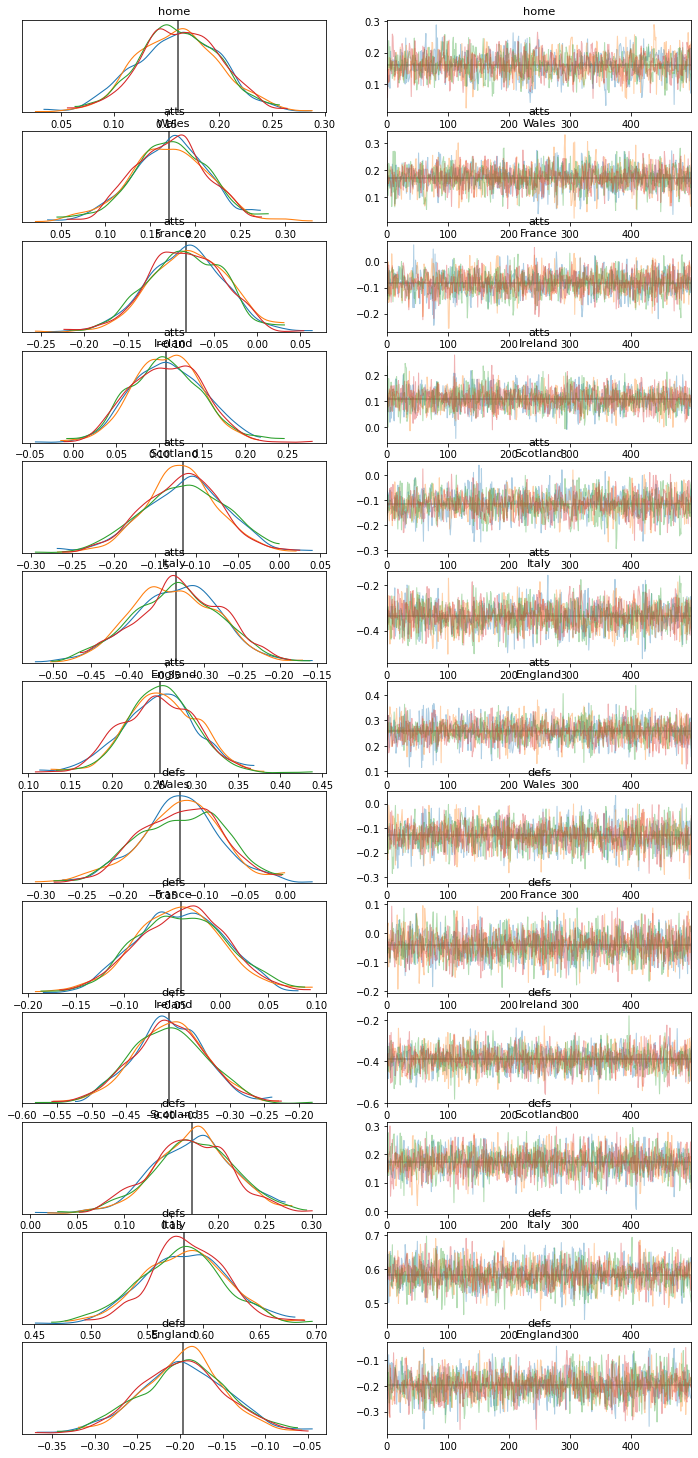

In [6]:
var_names = ["home", "atts", "defs"]
lines = list(xarray_var_iter(idata.posterior[var_names].mean(dim=("chain", "draw"))))
az.plot_trace(idata, var_names=var_names, lines=lines);

And what about quantile lines? Lets plot the 10% and 90% quantile lines:

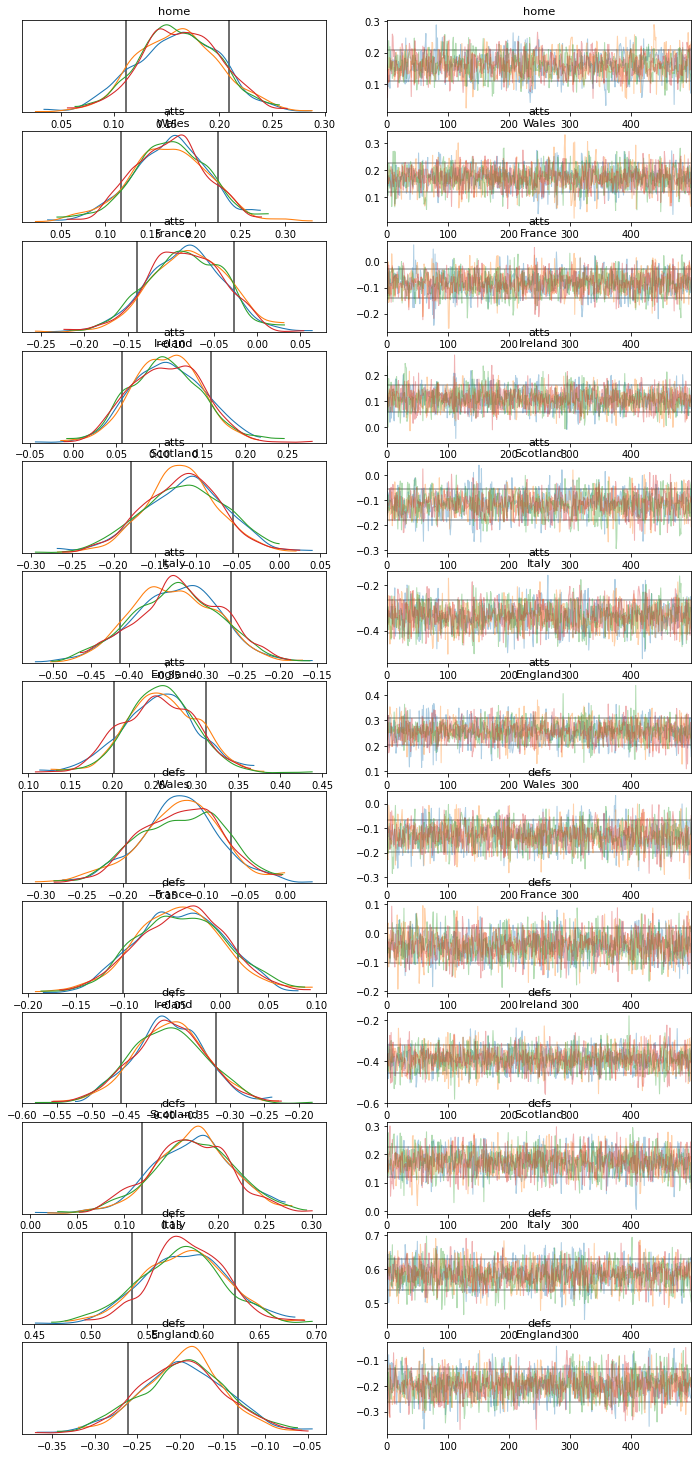

In [7]:
var_names = ["home", "atts", "defs"]
quantile_ds = idata.posterior[var_names].quantile((.1, .9), dim=("chain", "draw"))
lines = list(xarray_var_iter(quantile_ds, skip_dims={"quantile"}))
az.plot_trace(idata, var_names=var_names, lines=lines);

---
Comments are not enabled for the blog, to inquiry further about the contents of the post, ask on [ArviZ Issues](https://github.com/arviz-devs/arviz/issues) or [PyMC Discourse](https://discourse.pymc.io/)